# Tutorial: Native simulators vs. PyDDM Analytical Solutions

`ssm-simulators` allows you to define a `PyDDM` model via a wrapper class that let's us instantiate a `PyDDM` model from our `model_config`'s directly.

This notebook demonstrates the difference between:
1. **Native trajectory-based simulators** - Fast stochastic simulation of decision-making processes
2. **PyDDM analytical solutions** - Exact likelihood computation via Fokker-Planck equations

**What this notebook covers:**

- Understand when to use simulations vs. analytical solutions
- Compare speed and accuracy trade-offs
- Learn the API for both approaches
- Understand PyDDM compatibility requirements

### Module imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# SSM-Simulators imports
from ssms.basic_simulators.simulator import simulator  # Function-based
from ssms.basic_simulators.simulator_class import Simulator  # Class-based (recommended)
from ssms.config import model_config

# PyDDM imports (optional)
try:
    from ssms.external_simulators import SSMSToPyDDMMapper
    import pyddm
    PYDDM_AVAILABLE = True
    print("✓ PyDDM available")
except ImportError:
    PYDDM_AVAILABLE = False
    print("⚠ PyDDM not available (install with: pip install pyddm)")

# Set random seed for reproducibility
np.random.seed(42)
print("✓ All imports successful")

✓ PyDDM available
✓ All imports successful


## Native Trajectory-Based Simulation

Native simulators generate **stochastic trajectories** of the decision process.


In [2]:
# Example 1: Basic DDM simulation using class-based API (recommended)

# Create simulator instance
sim = Simulator(model="ddm")

# Define parameters
theta = {
    'v': 0.75,   # drift rate (positive = bias toward upper boundary)
    'a': 1.5,   # boundary separation (distance between boundaries)
    'z': 0.5,   # starting point (0.5 = unbiased, relative to 'a')
    't': 0.3    # non-decision time (encoding + motor execution)
}

# Run simulation
n_samples = 200000
start = time.time()
result = sim.simulate(
    theta=theta,
    n_samples=n_samples,
    delta_t=0.001,      # time step for numerical integration
    max_t=20.0,         # maximum decision time
    random_state=42     # for reproducibility
)
elapsed = time.time() - start

print(f"\nSimulated {n_samples:,} trials in {elapsed:.4f} seconds")
print(f"Speed: {n_samples/elapsed:,.0f} trials/second")
print(f"\nOutput keys: {list(result.keys())}")
print(f"RT shape: {result['rts'].shape}")
print(f"Choice shape: {result['choices'].shape}")
print(f"Unique choices: {np.unique(result['choices'])}")
print(f"\nMetadata: {result['metadata']}")



Simulated 200,000 trials in 1.7680 seconds
Speed: 113,125 trials/second

Output keys: ['rts', 'choices', 'metadata']
RT shape: (200000, 1)
Choice shape: (200000, 1)
Unique choices: [-1  1]

Metadata: {'simulator': 'ddm_flexbound', 'possible_choices': [-1, 1], 'n_samples': 200000, 'n_trials': 1, 'boundary_fun_type': 'constant', 'v': array([0.75], dtype=float32), 'a': array([1.5], dtype=float32), 'z': array([0.5], dtype=float32), 't': array([0.3], dtype=float32), 's': array([1.], dtype=float32), 'deadline': array([999.], dtype=float32), 'delta_t': 0.0010000000474974513, 'max_t': 20.0, 'boundary': array([1.5, 1.5, 1.5, ..., 1.5, 1.5, 1.5], shape=(20001,), dtype=float32), 'trajectory': array([[ 0.0000000e+00],
       [ 5.2374993e-03],
       [-4.6775356e-02],
       ...,
       [-9.9900000e+02],
       [-9.9900000e+02],
       [-9.9900000e+02]], shape=(20001, 1), dtype=float32), 'model': 'ddm'}


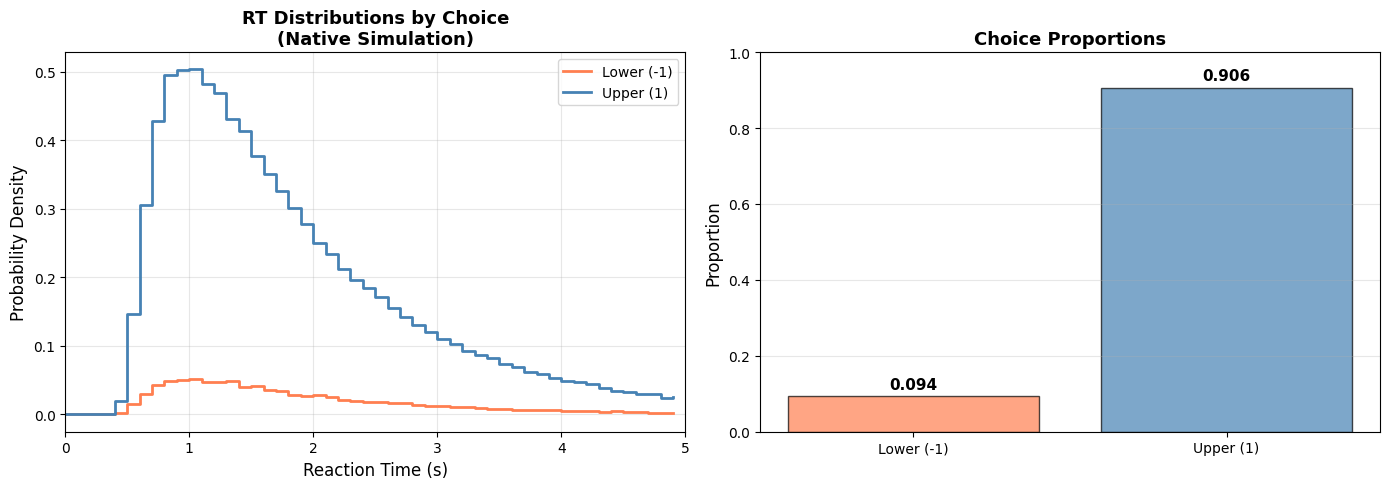


Summary Statistics:
Mean RT: 1.946 s
Median RT: 1.589 s
Std RT: 1.245 s
P(Upper): 0.906


In [3]:
# Visualize simulation results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. RT distributions by choice
# Note: Each choice has a defective distribution (doesn't integrate to 1)
# The correct normalization is by the total number of trials, not per-choice
choices_unique, counts = np.unique(result['choices'], return_counts=True)
proportions = counts / counts.sum()
n_total = len(result['rts'])

for choice, prop in zip([-1, 1], [proportions[0], proportions[1]]):
    mask = result['choices'] == choice
    rts = result['rts'][mask]
    label = 'Upper (1)' if choice == 1 else 'Lower (-1)'
    color = 'steelblue' if choice == 1 else 'coral'
    
    # Manually compute histogram with correct normalization
    counts_hist, bins = np.histogram(rts, bins=50, range=(0, 5))
    bin_width = bins[1] - bins[0]
    # Normalize by total trials (not just trials for this choice) to get proper PDF
    pdf = counts_hist / (n_total * bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    axes[0].plot(bins[:-1], pdf, drawstyle='steps-post', label=label, 
                color=color, linewidth=2)

axes[0].set_xlabel('Reaction Time (s)', fontsize=12)
axes[0].set_ylabel('Probability Density', fontsize=12)
axes[0].set_title('RT Distributions by Choice\n(Native Simulation)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 5])

# 2. Choice proportions
bars = axes[1].bar(['Lower (-1)', 'Upper (1)'], proportions, 
                    color=['coral', 'steelblue'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Proportion', fontsize=12)
axes[1].set_title('Choice Proportions', fontsize=13, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(alpha=0.3, axis='y')

for i, prop in enumerate(proportions):
    axes[1].text(i, prop + 0.02, f'{prop:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nSummary Statistics:")
print(f"Mean RT: {result['rts'].mean():.3f} s")
print(f"Median RT: {np.median(result['rts']):.3f} s")
print(f"Std RT: {result['rts'].std():.3f} s")
print(f"P(Upper): {proportions[1]:.3f}")


## PyDDM Analytical Solutions

PyDDM solves the **Fokker-Planck equation** numerically to compute exact probability distributions.

**Advantages:**
- ✓ **Exact** likelihood computation (no Monte Carlo noise)
- ✓ Deterministic results (same parameters = same answer)

**Limitations:**
- ✗ Only works for **compatible models**:
  - Single-particle, two-choice models
  - Gaussian noise only
  - Examples: DDM, Ornstein-Uhlenbeck, collapsing bounds
- ✗ Not compatible with: LBA, race models, LCA, non-Gaussian noise

**Note**

Requires PyDDM package (`pip install pyddm`)


In [4]:
# Define generator config (optional - defaults to delta_t=0.001, max_t=20.0)
# We'll define it explicitly here to match the simulation parameters
generator_config = {
    'delta_t': 0.001,  # Time step for numerical integration
    'max_t': 20.0      # Maximum decision time
}

# Build PyDDM model from ssms config using the mapper
print("\n1. Building PyDDM model from ssms configuration...")
pyddm_model = SSMSToPyDDMMapper.build_pyddm_model(
    model_config=model_config['ddm'],
    theta=theta,
    generator_config=generator_config  # Optional - can be omitted for defaults
)

print(f"   ✓ Model built: {pyddm_model}")
print(f"   Time domain: {len(pyddm_model.t_domain())} points")
print(f"   dt = {pyddm_model.dt}")
print(f"   T_dur = {pyddm_model.T_dur}")

# Solve the Fokker-Planck equation
print("\n2. Solving Fokker-Planck equation...")
start = time.time()
solution = pyddm_model.solve()
elapsed = time.time() - start

print(f"   ✓ Solved in {elapsed:.4f} seconds")

# Get analytical probabilities
p_correct = solution.prob("correct")
p_error = solution.prob("error")
p_undecided = solution.prob_undecided()

print(f"\n3. Analytical Probabilities:")
print(f"   P(Upper boundary):  {p_correct:.6f}")
print(f"   P(Lower boundary):  {p_error:.6f}")
print(f"   P(Undecided):       {p_undecided:.6f}")
print(f"   Total:              {p_correct + p_error + p_undecided:.6f}")

# Compare with simulation
print(f"\n4. Comparison with Simulation:")
print(f"   Simulation P(Upper): {proportions[1]:.6f}")
print(f"   PyDDM P(Upper):      {p_correct:.6f}")
print(f"   Absolute Difference: {abs(proportions[1] - p_correct):.6f}")
print(f"   Relative Error:      {abs(proportions[1] - p_correct)/p_correct*100:.2f}%")



1. Building PyDDM model from ssms configuration...
   ✓ Model built: Model(name='',
      drift=DriftEasy(),
      noise=NoiseConstant(noise=1),
      bound=BoundEasy(),
      IC=ICPointRatio(x0=0.0),
      overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=0.3), OverlayMixtureEasy()]),
      dx=0.005,
      dt=0.001,
      T_dur=20.0)
   Time domain: 20001 points
   dt = 0.001
   T_dur = 20.0

2. Solving Fokker-Planck equation...
   ✓ Solved in 0.2229 seconds

3. Analytical Probabilities:
   P(Upper boundary):  0.904561
   P(Lower boundary):  0.095339
   P(Undecided):       0.000100
   Total:              1.000000

4. Comparison with Simulation:
   Simulation P(Upper): 0.906340
   PyDDM P(Upper):      0.904561
   Absolute Difference: 0.001779
   Relative Error:      0.20%


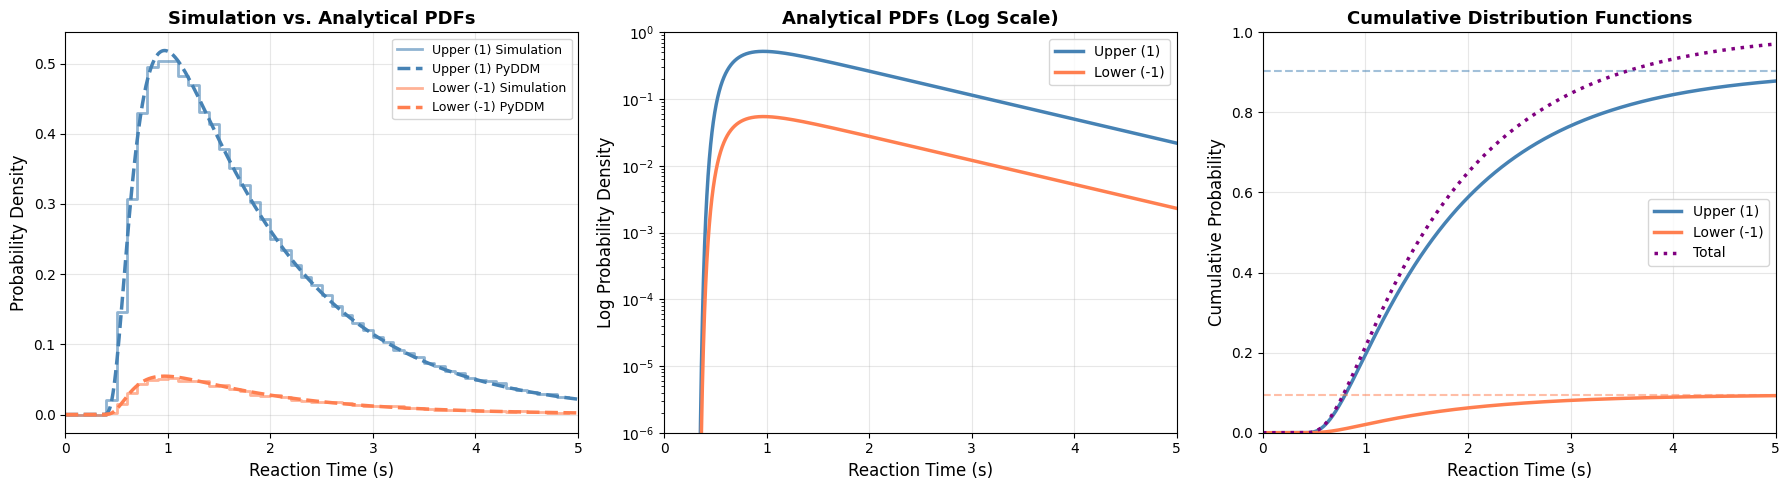

✓ Analytical PDFs match simulation histograms very closely!


In [5]:
# Visualize analytical PDFs and compare with simulation
t_domain = pyddm_model.t_domain()
pdf_correct = solution.pdf("correct")
pdf_error = solution.pdf("error")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Get choice proportions for proper normalization
n_total = len(result['rts'])

# 1. Compare PDFs with simulation histograms
for choice, pdf, label, color in [(1, pdf_correct, 'Upper (1)', 'steelblue'),
                                   (-1, pdf_error, 'Lower (-1)', 'coral')]:
    mask = result['choices'] == choice
    rts = result['rts'][mask]
    
    # Simulation histogram with proper normalization (defective distribution)
    counts_hist, bins = np.histogram(rts, bins=50, range=(0, 5))
    bin_width = bins[1] - bins[0]
    pdf_sim = counts_hist / (n_total * bin_width)
    
    axes[0].plot(bins[:-1], pdf_sim, drawstyle='steps-post', 
                label=f'{label} Simulation', color=color, linewidth=2, alpha=0.6)
    
    # Analytical PDF
    axes[0].plot(t_domain, pdf, linewidth=2.5, label=f'{label} PyDDM', 
                 color=color, linestyle='--')

axes[0].set_xlabel('Reaction Time (s)', fontsize=12)
axes[0].set_ylabel('Probability Density', fontsize=12)
axes[0].set_title('Simulation vs. Analytical PDFs', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 5])

# 2. Log-scale comparison (better for tails)
axes[1].semilogy(t_domain, pdf_correct, linewidth=2.5, label='Upper (1)', color='steelblue')
axes[1].semilogy(t_domain, pdf_error, linewidth=2.5, label='Lower (-1)', color='coral')
axes[1].set_xlabel('Reaction Time (s)', fontsize=12)
axes[1].set_ylabel('Log Probability Density', fontsize=12)
axes[1].set_title('Analytical PDFs (Log Scale)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 5])
axes[1].set_ylim([1e-6, 1])

# 3. Cumulative distribution functions
from scipy import integrate
cdf_correct = np.array([integrate.simpson(pdf_correct[:i+1], t_domain[:i+1]) 
                        for i in range(len(t_domain))])
cdf_error = np.array([integrate.simpson(pdf_error[:i+1], t_domain[:i+1]) 
                      for i in range(len(t_domain))])

axes[2].plot(t_domain, cdf_correct, linewidth=2.5, label='Upper (1)', color='steelblue')
axes[2].plot(t_domain, cdf_error, linewidth=2.5, label='Lower (-1)', color='coral')
axes[2].plot(t_domain, cdf_correct + cdf_error, linewidth=2.5, 
            label='Total', color='purple', linestyle=':')
axes[2].axhline(p_correct, color='steelblue', linestyle='--', alpha=0.5)
axes[2].axhline(p_error, color='coral', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Reaction Time (s)', fontsize=12)
axes[2].set_ylabel('Cumulative Probability', fontsize=12)
axes[2].set_title('Cumulative Distribution Functions', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(alpha=0.3)
axes[2].set_xlim([0, 5])
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("✓ Analytical PDFs match simulation histograms very closely!")


## API Comparison

This section gives a concrete example that contrasts how to instantiate simulators via our native `Simulator()` class and via the `SSMToPyDDMMapper()` class.

In [6]:
# ============================================================================
# METHOD 1: Class-based Simulator (RECOMMENDED - Modern, Object-Oriented)
# ============================================================================
print("\n>>> METHOD 1: Class-based Simulator (Recommended)")
print("-" * 60)

# Step 1: Create a simulator instance
sim_class = Simulator(model="ddm")
print(f"✓ Created Simulator instance: {sim_class}")

# Step 2: Define parameters as a dictionary (clean, readable)
theta_dict = {
    'v': 0.5,   # drift rate
    'a': 1.0,   # boundary separation
    'z': 0.5,   # starting point (relative)
    't': 0.2    # non-decision time
}
print(f"✓ Parameters: {theta_dict}")

# Step 3: Run simulation
start = time.time()
result_class = sim_class.simulate(
    theta=theta_dict,
    n_samples=1000,
    delta_t=0.001,
    max_t=20.0,
    random_state=123
)
elapsed_class = time.time() - start

print(f"✓ Simulated {len(result_class['rts'])} trials in {elapsed_class:.4f}s")
print(f"  Mean RT: {result_class['rts'].mean():.3f}s")
print(f"  P(Upper): {(result_class['choices'] == 1).mean():.3f}")


# ============================================================================
# METHOD 2: Function-based simulator (LEGACY - Older, Array-based)
# ============================================================================
print("\n\n>>> METHOD 2: Function-based simulator (Legacy)")
print("-" * 60)

# Step 1: Convert parameters to array format
# Order MUST match model_config['ddm']['params']: ['v', 'a', 'z', 't']
theta_array = np.array([[0.5, 1.0, 0.5, 0.2]])  # Must be 2D array!
print(f"✓ Parameters as array: {theta_array}")
print(f"  Shape: {theta_array.shape} (n_trials, n_params)")

# Step 2: Call simulator function
start = time.time()
result_func = simulator(
    theta=theta_array,
    model="ddm",
    n_samples=1000,
    delta_t=0.001,
    max_t=20.0,
    random_state=123
)
elapsed_func = time.time() - start

print(f"✓ Simulated {len(result_func['rts'])} trials in {elapsed_func:.4f}s")
print(f"  Mean RT: {result_func['rts'].mean():.3f}s")
print(f"  P(Upper): {(result_func['choices'] == 1).mean():.3f}")


# ============================================================================
# COMPARISON
# ============================================================================
print("\n\n>>> COMPARISON")
print("-" * 60)
print(f"{'Feature':<30} {'Class-based':<20} {'Function-based':<20}")
print("-" * 60)
print(f"{'Parameters':<30} {'Dict (readable)':<20} {'Array (error-prone)':<20}")
print(f"{'Code style':<30} {'Object-oriented':<20} {'Procedural':<20}")
print(f"{'Reusability':<30} {'Create once, use many':<20} {'Call each time':<20}")
print(f"{'Error checking':<30} {'Built-in':<20} {'Manual':<20}")
print(f"{'Recommendation':<30} {'✓ USE THIS':<20} {'Legacy only':<20}")
print("-" * 60)

# Verify results are identical (same random seed)
assert np.allclose(result_class['rts'], result_func['rts']), "Results should match!"
assert np.allclose(result_class['choices'], result_func['choices']), "Choices should match!"
print("\n✓ Both methods produce identical results (as expected)")


# ============================================================================
# KEY DIFFERENCES EXPLAINED
# ============================================================================
print("\n\n>>> KEY DIFFERENCES")
print("-" * 60)
print("""
1. PARAMETER FORMAT:
   - Class-based: theta = {'v': 0.5, 'a': 1.0, ...}  ← Self-documenting!
   - Function-based: theta = [[0.5, 1.0, ...]]      ← What is 0.5?

2. REUSABILITY:
   - Class-based: sim = Simulator(model='ddm')      ← Create once
                  sim.simulate(theta1, ...)         ← Use many times
                  sim.simulate(theta2, ...)
   - Function-based: simulator(theta1, model='ddm', ...)  ← Repeat model name
                     simulator(theta2, model='ddm', ...)  ← each time

3. ERROR PREVENTION:
   - Class-based: Validates parameter names automatically
   - Function-based: Wrong order = silent errors!
   
4. FUTURE COMPATIBILITY:
   - Class-based: ✓ All new features added here first
   - Function-based: Maintained for backward compatibility only

RECOMMENDATION: Always use Simulator(model='...').simulate(...) for new code!
""")



>>> METHOD 1: Class-based Simulator (Recommended)
------------------------------------------------------------
✓ Created Simulator instance: <ssms.basic_simulators.simulator_class.Simulator object at 0x17f2fcad0>
✓ Parameters: {'v': 0.5, 'a': 1.0, 'z': 0.5, 't': 0.2}
✓ Simulated 1000 trials in 0.0064s
  Mean RT: 1.188s
  P(Upper): 0.738


>>> METHOD 2: Function-based simulator (Legacy)
------------------------------------------------------------
✓ Parameters as array: [[0.5 1.  0.5 0.2]]
  Shape: (1, 4) (n_trials, n_params)
✓ Simulated 1000 trials in 0.0062s
  Mean RT: 1.188s
  P(Upper): 0.738


>>> COMPARISON
------------------------------------------------------------
Feature                        Class-based          Function-based      
------------------------------------------------------------
Parameters                     Dict (readable)      Array (error-prone) 
Code style                     Object-oriented      Procedural          
Reusability                    Create on

## Likelihood Evaluation Comparison

We compare:

1. **KDE from simulations** - Approximate likelihood via kernel density estimation
2. **PyDDM analytical PDF** - Exact likelihood via interpolation


In [7]:
from ssms.support_utils.kde_class import LogKDE
from scipy.interpolate import interp1d

# Build KDE from simulation
print("\n1. Building KDE from simulated data...")
start = time.time()
kde = LogKDE(result, displace_t=False)
kde_time = time.time() - start
print(f"   ✓ KDE built in {kde_time:.4f} seconds")

# Create PyDDM interpolator
print("\n2. Creating PyDDM interpolator...")
start = time.time()
interp_correct = interp1d(t_domain, pdf_correct, kind='cubic', 
                            bounds_error=False, fill_value=0.0)
interp_error = interp1d(t_domain, pdf_error, kind='cubic',
                        bounds_error=False, fill_value=0.0)
interp_time = time.time() - start
print(f"   ✓ Interpolator created in {interp_time:.4f} seconds")

# Generate test points
n_test = 1000
test_rts = np.random.uniform(0.5, 3.0, n_test)
test_choices = np.random.choice([-1, 1], n_test)

# Evaluate KDE
print(f"\n3. Evaluating likelihood at {n_test} test points...")
start = time.time()
kde_logliks = kde.kde_eval({'rts': test_rts, 'choices': test_choices})
kde_eval_time = time.time() - start
print(f"   KDE evaluation:")
print(f"     Time:  {kde_eval_time:.4f} seconds")
print(f"     Speed: {n_test/kde_eval_time:,.0f} evaluations/second")

# Evaluate PyDDM
start = time.time()
pyddm_pdfs = np.where(
    test_choices == 1,
    interp_correct(test_rts),
    interp_error(test_rts)
)
pyddm_logliks = np.log(np.clip(pyddm_pdfs, 1e-29, None))
pyddm_eval_time = time.time() - start
print(f"\n   PyDDM evaluation:")
print(f"     Time:  {pyddm_eval_time:.4f} seconds")
print(f"     Speed: {n_test/pyddm_eval_time:,.0f} evaluations/second")
print(f"     Speedup: {kde_eval_time/pyddm_eval_time:.1f}x faster than KDE")



1. Building KDE from simulated data...
   ✓ KDE built in 0.0339 seconds

2. Creating PyDDM interpolator...
   ✓ Interpolator created in 0.0087 seconds

3. Evaluating likelihood at 1000 test points...
   KDE evaluation:
     Time:  3.4674 seconds
     Speed: 288 evaluations/second

   PyDDM evaluation:
     Time:  0.0017 seconds
     Speed: 586,452 evaluations/second
     Speedup: 2033.4x faster than KDE


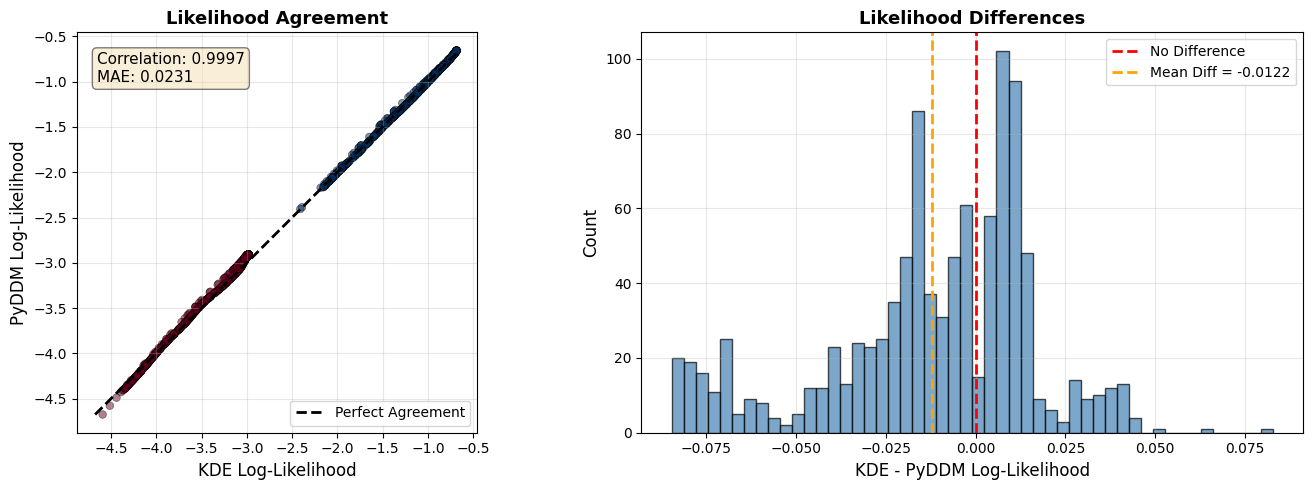


✓ PyDDM and KDE likelihoods are highly correlated (r = 0.9997)
✓ PyDDM is 2033.4x faster for likelihood evaluation


In [8]:
# Visualize likelihood comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Likelihood comparison scatter
axes[0].scatter(kde_logliks, pyddm_logliks, alpha=0.5, s=30, 
                c=test_choices, cmap='RdBu', edgecolors='black', linewidth=0.5)

# Add diagonal line (perfect agreement)
lim_min = min(kde_logliks.min(), pyddm_logliks.min())
lim_max = max(kde_logliks.max(), pyddm_logliks.max())
axes[0].plot([lim_min, lim_max], [lim_min, lim_max], 'k--', 
            linewidth=2, label='Perfect Agreement')

axes[0].set_xlabel('KDE Log-Likelihood', fontsize=12)
axes[0].set_ylabel('PyDDM Log-Likelihood', fontsize=12)
axes[0].set_title('Likelihood Agreement', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_aspect('equal')

# Compute correlation
corr = np.corrcoef(kde_logliks, pyddm_logliks)[0, 1]
mae = np.mean(np.abs(kde_logliks - pyddm_logliks))
axes[0].text(0.05, 0.95, f'Correlation: {corr:.4f}\nMAE: {mae:.4f}',
            transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Difference histogram
diff = kde_logliks - pyddm_logliks
axes[1].hist(diff, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='No Difference')
axes[1].axvline(diff.mean(), color='orange', linestyle='--', linewidth=2, 
                label=f'Mean Diff = {diff.mean():.4f}')
axes[1].set_xlabel('KDE - PyDDM Log-Likelihood', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Likelihood Differences', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ PyDDM and KDE likelihoods are highly correlated (r = {corr:.4f})")
print(f"✓ PyDDM is {kde_eval_time/pyddm_eval_time:.1f}x faster for likelihood evaluation")


## Model Compatibility

Not all models are compatible with PyDDM. Let's check which models work with both approaches.


In [9]:
# Test a selection of models
test_models = [
    'ddm',           # Standard DDM
    'angle',         # DDM with collapsing bounds
    'ornstein',      # Ornstein-Uhlenbeck process
    'weibull',       # Weibull hazard model
    'full_ddm',      # Full DDM with bias and drift variability
    'lba2',           # Linear Ballistic Accumulator
    'race_no_bias_2',  # Race model (2 accumulators)
    'lca_3',           # Leaky Competing Accumulator
]

# Check compatibility
results = []
for model_name in test_models:
    # Check if model is in config
    if model_name not in model_config:
        results.append({
            'Model': model_name,
            'Native': '✗ (not found)',
            'PyDDM': '✗',
            'Notes': 'Model not in configuration'
        })
        continue
    
    # Try native simulator
    try:
        sim_test = Simulator(model=model_name)
        native_ok = True
    except Exception as e:
        native_ok = False
        native_error = str(e)[:50]

    try:
        test_theta = {p: 1.0 for p in model_config[model_name]['params'][:4]}
        pyddm_model = SSMSToPyDDMMapper.build_pyddm_model(
            model_config=model_config[model_name],
            theta=test_theta,
            generator_config=generator_config  # Use the same config defined earlier
        )
        pyddm_ok = True
    except Exception as e:
        pyddm_ok = False
        pyddm_error = str(e)[:50]
    
    # Determine notes
    if native_ok and pyddm_ok:
        notes = "✓ Both methods work"
    elif native_ok and not pyddm_ok:
        notes = f"PyDDM error: {pyddm_error if not PYDDM_AVAILABLE else 'Not compatible'}"
    elif not native_ok:
        notes = f"Native error: {native_error}"
    else:
        notes = "Both failed"
    
    results.append({
        'Model': model_name,
        'Native': '✓' if native_ok else '✗',
        'PyDDM': '✓' if pyddm_ok else '✗',
        'Notes': notes
    })

# Display as table
df = pd.DataFrame(results)
print("\n")
print(df.to_string(index=False))

print("\n" + "=" * 60)
print("Summary:")
native_count = sum(1 for r in results if r['Native'] == '✓')
pyddm_count = sum(1 for r in results if r['PyDDM'] == '✓')
print(f"Native simulators work: {native_count}/{len(results)}")
print(f"PyDDM compatible:       {pyddm_count}/{len(results)}")
print("=" * 60)




         Model Native PyDDM                       Notes
           ddm      ✓     ✓         ✓ Both methods work
         angle      ✓     ✓         ✓ Both methods work
      ornstein      ✓     ✓         ✓ Both methods work
       weibull      ✓     ✓         ✓ Both methods work
      full_ddm      ✓     ✗ PyDDM error: Not compatible
          lba2      ✓     ✗ PyDDM error: Not compatible
race_no_bias_2      ✓     ✗ PyDDM error: Not compatible
         lca_3      ✓     ✗ PyDDM error: Not compatible

Summary:
Native simulators work: 8/8
PyDDM compatible:       4/8


## Advanced Example - Collapsing Bounds

Let's demonstrate a more complex model: the **angle** model with collapsing decision bounds.



1. Running angle model simulation...


   ✓ Simulated 5000 trials
   Mean RT: 0.926s

2. Comparing with standard DDM...

3. Building PyDDM model for angle (collapsing bounds)...
   ✓ PyDDM angle model solved
   P(Upper | angle): 0.8377
   P(Upper | DDM):   0.9046


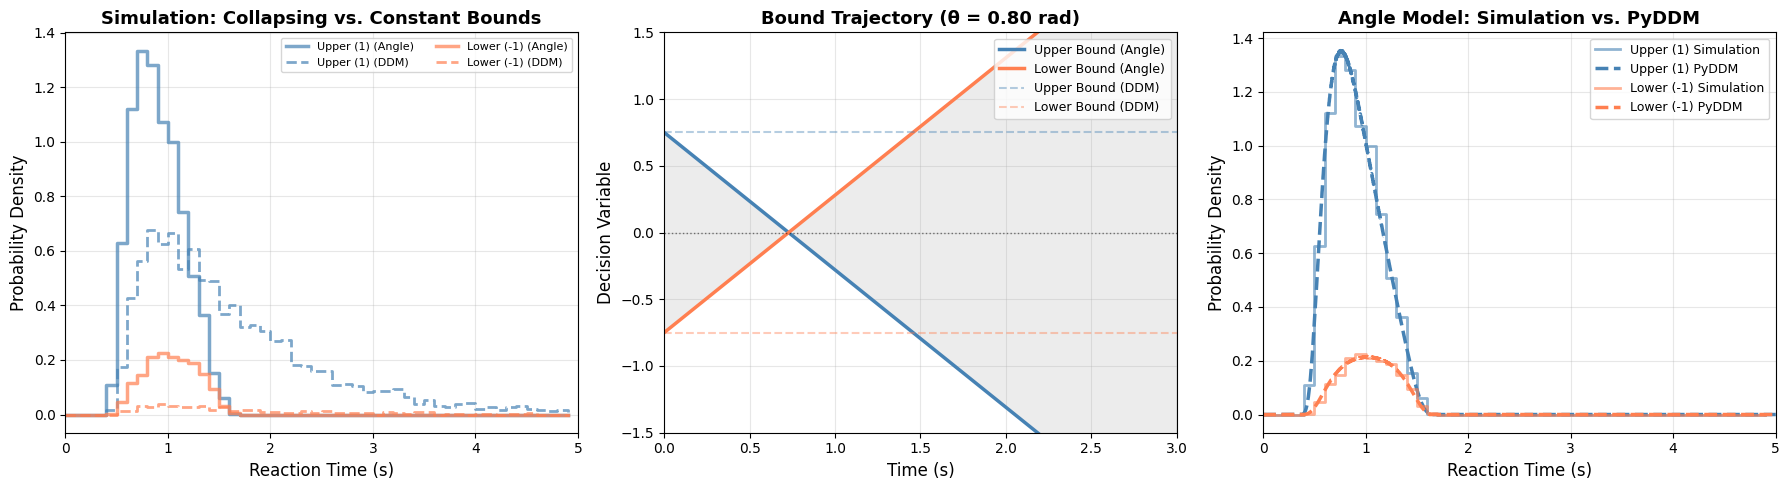


✓ Collapsing bounds lead to faster decisions (shorter tail in RT distribution)


In [10]:
# Create angle model simulator
angle_sim = Simulator(model="angle")

# Parameters for angle model
angle_theta = {
    'v': 1.0,     # drift rate
    'a': 1.5,     # initial boundary separation
    'z': 0.5,     # starting point
    't': 0.3,     # non-decision time
    'theta': 0.8  # collapse angle (radians)
}

# Simulate
print("\n1. Running angle model simulation...")
angle_result = angle_sim.simulate(
    theta=angle_theta,
    n_samples=5000,
    delta_t=0.001,
    max_t=20.0,
    random_state=42
)

print(f"   ✓ Simulated {len(angle_result['rts'])} trials")
print(f"   Mean RT: {angle_result['rts'].mean():.3f}s")

# Compare with standard DDM
print("\n2. Comparing with standard DDM...")
ddm_result_compare = sim.simulate(
    theta={'v': 1.0, 'a': 1.5, 'z': 0.5, 't': 0.3},
    n_samples=5000,
    delta_t=0.001,
    max_t=20.0,
    random_state=42
)

# Get PyDDM analytical solution for angle model (if available)
print("\n3. Building PyDDM model for angle (collapsing bounds)...")
pyddm_angle_model = SSMSToPyDDMMapper.build_pyddm_model(
    model_config=model_config['angle'],
    theta=angle_theta
    # Using default generator_config
)
angle_solution = pyddm_angle_model.solve()
angle_pdf_correct = angle_solution.pdf("correct")
angle_pdf_error = angle_solution.pdf("error")
angle_t_domain = pyddm_angle_model.t_domain()
print(f"   ✓ PyDDM angle model solved")
print(f"   P(Upper | angle): {angle_solution.prob('correct'):.4f}")
print(f"   P(Upper | DDM):   {p_correct:.4f}")

# Visualize collapsing bounds effect
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RT distributions with proper normalization
n_angle = len(angle_result['rts'])
n_ddm = len(ddm_result_compare['rts'])

# 1. Compare simulation: Angle vs. DDM
for choice, label, color in [(1, 'Upper (1)', 'steelblue'), (-1, 'Lower (-1)', 'coral')]:
    # Angle model - properly normalized defective distribution
    angle_mask = angle_result['choices'] == choice
    angle_rts = angle_result['rts'][angle_mask]
    counts_angle, bins = np.histogram(angle_rts, bins=50, range=(0, 5))
    bin_width = bins[1] - bins[0]
    pdf_angle = counts_angle / (n_angle * bin_width)
    axes[0].plot(bins[:-1], pdf_angle, drawstyle='steps-post', 
                label=f'{label} (Angle)', color=color, linewidth=2.5, alpha=0.7)
    
    # Standard DDM - properly normalized defective distribution
    ddm_mask = ddm_result_compare['choices'] == choice
    ddm_rts = ddm_result_compare['rts'][ddm_mask]
    counts_ddm, bins = np.histogram(ddm_rts, bins=50, range=(0, 5))
    pdf_ddm = counts_ddm / (n_ddm * bin_width)
    axes[0].plot(bins[:-1], pdf_ddm, drawstyle='steps-post', 
                label=f'{label} (DDM)', color=color, linewidth=2, linestyle='--', alpha=0.7)

axes[0].set_xlabel('Reaction Time (s)', fontsize=12)
axes[0].set_ylabel('Probability Density', fontsize=12)
axes[0].set_title('Simulation: Collapsing vs. Constant Bounds', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=8, ncol=2)
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 5])

# 2. Visualize bound collapse trajectory
t_plot = np.linspace(0, 3, 100)
upper_bound_angle = angle_theta['a'] / 2 - t_plot * np.tan(angle_theta['theta'])
lower_bound_angle = -angle_theta['a'] / 2 + t_plot * np.tan(angle_theta['theta'])

axes[1].plot(t_plot, upper_bound_angle, color='steelblue', linewidth=2.5, 
            label='Upper Bound (Angle)', linestyle='-')
axes[1].plot(t_plot, lower_bound_angle, color='coral', linewidth=2.5, 
            label='Lower Bound (Angle)', linestyle='-')
axes[1].axhline(angle_theta['a']/2, color='steelblue', linestyle='--', 
               alpha=0.4, linewidth=1.5, label='Upper Bound (DDM)')
axes[1].axhline(-angle_theta['a']/2, color='coral', linestyle='--', 
               alpha=0.4, linewidth=1.5, label='Lower Bound (DDM)')
axes[1].fill_between(t_plot, lower_bound_angle, upper_bound_angle, alpha=0.15, color='gray')
axes[1].axhline(0, color='black', linestyle=':', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Decision Variable', fontsize=12)
axes[1].set_title(f'Bound Trajectory (θ = {angle_theta["theta"]:.2f} rad)', 
                 fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9, loc='upper right')
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 3])
axes[1].set_ylim([-1.5, 1.5])

# 3. Compare angle simulation with PyDDM analytical
for choice, pdf, label, color in [(1, angle_pdf_correct, 'Upper (1)', 'steelblue'),
                                    (-1, angle_pdf_error, 'Lower (-1)', 'coral')]:
    # Simulation histogram
    mask = angle_result['choices'] == choice
    rts = angle_result['rts'][mask]
    counts_hist, bins = np.histogram(rts, bins=50, range=(0, 5))
    bin_width = bins[1] - bins[0]
    pdf_sim = counts_hist / (n_angle * bin_width)
    
    axes[2].plot(bins[:-1], pdf_sim, drawstyle='steps-post', 
                label=f'{label} Simulation', color=color, linewidth=2, alpha=0.6)
    
    # PyDDM analytical
    axes[2].plot(angle_t_domain, pdf, linewidth=2.5, label=f'{label} PyDDM', 
                color=color, linestyle='--')

    axes[2].set_xlabel('Reaction Time (s)', fontsize=12)
    axes[2].set_ylabel('Probability Density', fontsize=12)
    axes[2].set_title('Angle Model: Simulation vs. PyDDM', fontsize=13, fontweight='bold')
    axes[2].legend(fontsize=9)
    axes[2].grid(alpha=0.3)
    axes[2].set_xlim([0, 5])

plt.tight_layout()
plt.show()

print("\n✓ Collapsing bounds lead to faster decisions (shorter tail in RT distribution)")
